In [1]:
import numpy as np
import os, sys, time

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from Sampling import Gaussian_sample

In [3]:
cuda = torch.cuda.is_available()
h_dims = [200, 100]
z_dim = 32

In [4]:
class Encoder(nn.Module):
    def __init__(self, dims, dataset='mnist'):
        super(Encoder, self).__init__()
        [x_dim, h_dim, z_dim] = dims
        neurons = [x_dim, *h_dim]
        linear_layers = [nn.Linear(neurons[i-1], neurons[i]) for i in range(1, len(neurons))]
        self.h= nn.ModuleList(modules=linear_layers)
        self.sample = Gaussian_sample(h_dim[-1], z_dim)
    
    def forward(self, x):
        for i, next_layer in enumerate(self.h):
            x = next_layer(x)
            if i < len(self.h) - 1:
                x = F.softplus(x)
        return self.sample(x)
    
    
class Decoder(nn.Module):
    def __init__(self, dims, dataset='mnist'):
        super(Decoder, self).__init__()
        [z_dim, h_dim, x_dim] = dims
        neurons = [z_dim, *h_dim]
        linear_layers = [nn.Linear(neurons[i-1], neurons[i]) for i in range(1, len(neurons))]
        self.h = nn.ModuleList(modules=linear_layers)
        self.output = nn.Linear(h_dim[-1], x_dim)
        
    def forward(self, x):
        for i, next_layer in enumerate(self.h):
            x=F.softplus(next_layer(x))
        return F.sigmoid(self.output(x))
    
    
class VAE(nn.Module):
    def __init__(self, dims):
        super(VAE, self).__init__()
        [x_dim, h_dim, self.z_dim] = dims
        self.encoder = Encoder([x_dim, h_dim, self.z_dim])
        self.decoder = Decoder([self.z_dim, list(reversed(h_dim)), x_dim])
        for module in self.modules():
            if isinstance(module, nn.Linear):
                init.xavier_normal(module.weight.data)
                if module.bias is not None:
                    module.bias.data.zero_()
    
    def forward(self, x):
        z, mu, logvar = self.encoder(x)
        x_reconstructed = self.decoder(z)
        return x_reconstructed, (z, mu, logvar)
    
    def sample(self, z):
        return self.decoder(z)

In [5]:
batch_size = 100

In [6]:
flatten_bernoulli = lambda img: transforms.ToTensor()(img).view(-1).bernoulli()
mnist = datasets.MNIST('../data/', train=True, transform=flatten_bernoulli, download=True)
mnist_val = datasets.MNIST('../data/', train=False, transform=flatten_bernoulli, download=True)

unlabeled = torch.utils.data.DataLoader(mnist, batch_size=batch_size, shuffle=True, num_workers=2)
validation = torch.utils.data.DataLoader(mnist_val, batch_size=batch_size, shuffle=True, num_workers=2)

In [7]:
vae = VAE([784, [200, 100], 20]).cuda()

In [8]:
reconstruction_fn = nn.BCELoss(size_average=False)
def loss_function(x_reconstructed, x, mu, logvar):
    reconstruction_error = reconstruction_fn(x_reconstructed, x)
    KL_div = 0.5*(1. + logvar - mu**2 - torch.exp(logvar))
    return reconstruction_error, torch.sum(KL_div)

In [9]:
opt = torch.optim.Adam(vae.parameters(), lr = 0.001)

In [10]:
n_epoch = 20

In [11]:
for epoch in range(n_epoch):
    for i, [image, label] in enumerate(unlabeled):
        opt.zero_grad()
        x = Variable(image)
        if cuda: x = x.cuda()
        recon_x, (z, mu, logvar) = vae(x)
        reconstruction_error, KL_div = loss_function(recon_x, x, mu, logvar)
        loss = reconstruction_error - KL_div
        loss.backward()
        opt.step()
    print("Epoch: {}, loss: {:.3f}".format(epoch+1, loss.data[0]))

Epoch: 1, loss: 14093.348
Epoch: 2, loss: 12545.267
Epoch: 3, loss: 11817.392
Epoch: 4, loss: 11303.359
Epoch: 5, loss: 10873.975
Epoch: 6, loss: 10737.401
Epoch: 7, loss: 10398.940
Epoch: 8, loss: 10530.702
Epoch: 9, loss: 10490.656
Epoch: 10, loss: 10378.930
Epoch: 11, loss: 10813.408
Epoch: 12, loss: 10272.074
Epoch: 13, loss: 9865.738
Epoch: 14, loss: 10397.357
Epoch: 15, loss: 9782.252
Epoch: 16, loss: 10258.327
Epoch: 17, loss: 9868.657
Epoch: 18, loss: 10039.827
Epoch: 19, loss: 9481.354
Epoch: 20, loss: 9630.166


In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

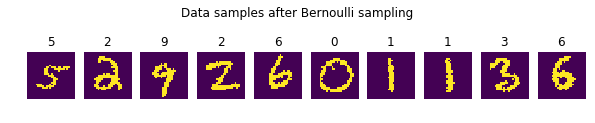

In [13]:
f, axarr = plt.subplots(1, 10, figsize=(10, 2))
for i in range(10):
    axarr[i].imshow(image[i].numpy().reshape(28, 28))
    title = label[i]
    axarr[i].set_title(title)
    axarr[i].axis("off")
    
f.suptitle("Data samples after Bernoulli sampling")
plt.show()

torch.Size([100, 784])


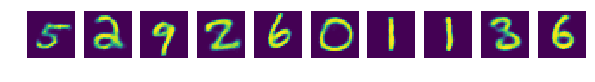

In [14]:
f, axarr = plt.subplots(1, 10, figsize=(10, 2))
out_img = torch.squeeze(recon_x.cpu().data)
print(out_img.size())
for i in range(10):
    axarr[i].imshow(out_img[i].numpy().reshape(28,28))
#     title = label[i]
#     axarr[i].set_title(title)
    axarr[i].axis("off")
plt.show()